In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_281.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_1.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_256.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_221.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_138.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_93.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_198.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_137.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_120.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_13.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_40.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_217.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_3.png
/kaggle/input/feature-selelcted-dataset/test/pneumonia/image_286.png
/kaggle/input/feature-selelcted-dataset/t

In [34]:
from tensorflow.keras.applications import VGG19, DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import cv2 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import mark_boundaries
import os
import random

In [3]:
base_path = "/kaggle/input/feature-selelcted-dataset"
categories = ['normal', 'covid19', 'pneumonia']
image_size = (224,224)

In [4]:
def load_images_from_folder(folder, label_name, images_list, labels_list):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            images_list.append(img)
            labels_list.append(label_name)

In [5]:
# Load training data
train_path = os.path.join(base_path, 'train')
train_images, train_labels = [], []

for category in categories:
    category_path = os.path.join(train_path, category)
    print(f"Loading training data from {category_path}...")
    load_images_from_folder(category_path, category, train_images, train_labels)

Loading training data from /kaggle/input/feature-selelcted-dataset/train/normal...
Loading training data from /kaggle/input/feature-selelcted-dataset/train/covid19...
Loading training data from /kaggle/input/feature-selelcted-dataset/train/pneumonia...


In [6]:
# Load test data
test_path = os.path.join(base_path, 'test')
test_images, test_labels = [], []

for category in categories:
    category_path = os.path.join(test_path, category)
    print(f"Loading test data from {category_path}...")
    load_images_from_folder(category_path, category, test_images, test_labels)

Loading test data from /kaggle/input/feature-selelcted-dataset/test/normal...
Loading test data from /kaggle/input/feature-selelcted-dataset/test/covid19...
Loading test data from /kaggle/input/feature-selelcted-dataset/test/pneumonia...


In [7]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [8]:
from sklearn.utils import shuffle

# Shuffle training data
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

# Shuffle test data
test_images, test_labels = shuffle(test_images, test_labels, random_state=42)

In [9]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [10]:
label_mapping = {'covid19': 0, 'pneumonia': 1,'normal': 2}

train_labels_int = np.array([label_mapping[label] for label in train_labels], dtype='int32')
test_labels_int = np.array([label_mapping[label] for label in test_labels], dtype='int32')

train_labels_one_hot = tf.keras.utils.to_categorical(train_labels_int, num_classes=3).astype('float32')
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels_int, num_classes=3).astype('float32')

In [11]:
def Fine_tuning_base_Model(model):
    model.trainable = False

    x = GlobalAveragePooling2D()(model.output)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(3, activation='softmax')(x)

    return Model(inputs=model.input, outputs=output)

# VGG19

In [12]:
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

I0000 00:00:1746286861.547890      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746286861.548665      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
vgg19_finetuned = Fine_tuning_base_Model(vgg19_model)

In [14]:
vgg19_finetuned.compile(optimizer=SGD(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
vgg19_history = vgg19_finetuned.fit(train_images, train_labels_one_hot, validation_split=0.15, epochs=50, batch_size=7)

Epoch 1/50


I0000 00:00:1746286867.213224      96 service.cc:148] XLA service 0x797110047be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746286867.214299      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746286867.214323      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746286867.618853      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/147 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.3095 - loss: 1.2983

I0000 00:00:1746286872.869852      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 113ms/step - accuracy: 0.3495 - loss: 1.2444 - val_accuracy: 0.4530 - val_loss: 1.0691
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.3786 - loss: 1.1476 - val_accuracy: 0.3867 - val_loss: 1.0448
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.4138 - loss: 1.0875 - val_accuracy: 0.6133 - val_loss: 1.0022
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.4470 - loss: 1.0508 - val_accuracy: 0.5856 - val_loss: 0.9787
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.4929 - loss: 1.0079 - val_accuracy: 0.6409 - val_loss: 0.9598
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.5203 - loss: 0.9926 - val_accuracy: 0.5525 - val_loss: 0.9431
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.5334 - loss: 0.9803 - val_accuracy: 0.6298 - val_loss: 0.9147
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.5827 - loss: 0.9306 - val_accura

In [16]:
print(vgg19_finetuned.summary())
print(vgg19_finetuned.output)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,090,437 (76.64 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 2 (12.00 B)

None
<KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_26>


In [17]:
vgg19_finetuned.save_weights('vgg19_fineTuned.weights.h5')

In [18]:
test_loss, test_accuracy = vgg19_finetuned.evaluate(test_images, test_labels_one_hot)

10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7928 - loss: 0.5864 


In [19]:
y_predicted_probabilities = vgg19_finetuned.predict(test_images)
y_predicted = np.argmax(y_predicted_probabilities, axis=1)
true_labels = test_labels_int

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step


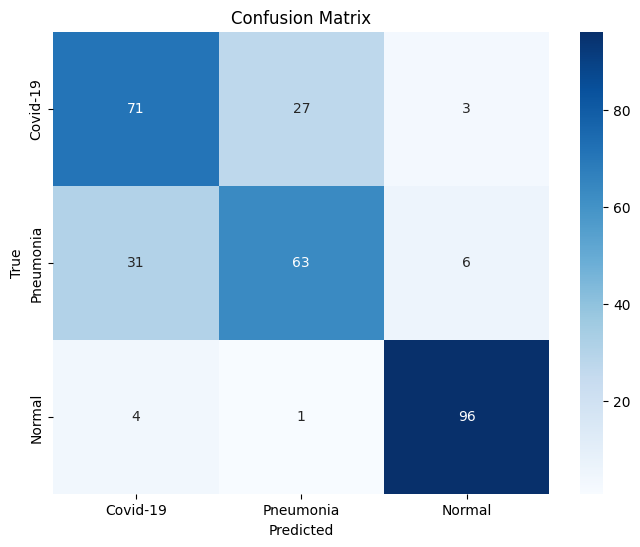

In [20]:
cm = confusion_matrix(true_labels, y_predicted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Covid-19', 'Pneumonia', 'Normal'], 
            yticklabels=['Covid-19', 'Pneumonia', 'Normal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True') 
plt.show()

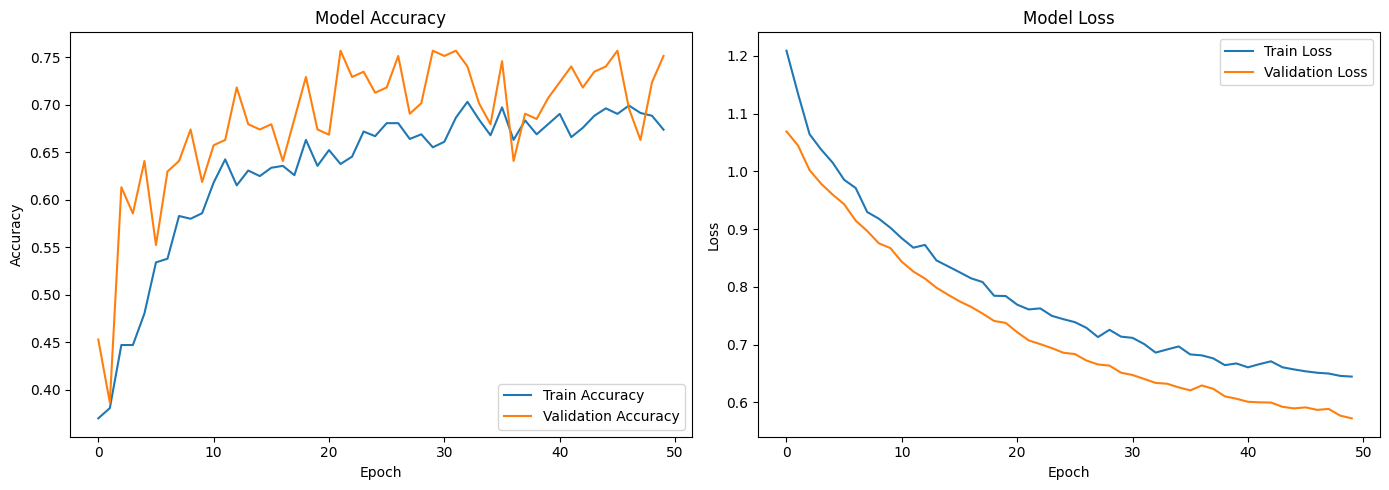

In [21]:
# Extract metrics from history
acc = vgg19_history.history['accuracy']
val_acc = vgg19_history.history['val_accuracy']
loss = vgg19_history.history['loss']
val_loss = vgg19_history.history['val_loss']

epochs_range = range(len(acc))

# Plot
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


# DenseNet121

In [35]:
DenseNet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [36]:
DenseNet121_finetuned = Fine_tuning_base_Model(DenseNet121_model)

In [37]:
DenseNet121_finetuned.compile(optimizer=SGD(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
DenseNet121_history = DenseNet121_finetuned.fit(train_images, train_labels_one_hot, validation_split=0.15, epochs=50, batch_size=7)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 68s 252ms/step - accuracy: 0.4873 - loss: 1.1666 - val_accuracy: 0.6961 - val_loss: 0.7052
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6393 - loss: 0.7239 - val_accuracy: 0.6961 - val_loss: 0.6120
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7030 - loss: 0.6711 - val_accuracy: 0.7182 - val_loss: 0.5683
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6904 - loss: 0.6589 - val_accuracy: 0.7293 - val_loss: 0.5496
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7458 - loss: 0.5881 - val_accuracy: 0.7238 - val_loss: 0.5279
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7384 - loss: 0.5741 - val_accuracy: 0.7514 - val_loss: 0.5183
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7473 - loss: 0.5552 - val_accuracy: 0.7624 - val_loss: 0.5004
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7475 - loss: 0.5449 - val_ac

In [39]:
print(DenseNet121_finetuned.summary())
print(DenseNet121_finetuned.output)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,169,093 (27.35 MB)

 Trainable params: 131,587 (514.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 2 (12.00 B)

None
<KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_1170>


In [40]:
DenseNet121_finetuned.save_weights('DenseNet121_finetuned.weights.h5')

In [41]:
test_loss, test_accuracy = DenseNet121_finetuned.evaluate(test_images, test_labels_one_hot)

10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 949ms/step - accuracy: 0.8208 - loss: 0.4011


In [42]:
y_predicted_probabilities = DenseNet121_finetuned.predict(test_images)
y_predicted = np.argmax(y_predicted_probabilities, axis=1)
true_labels = test_labels_int

10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step


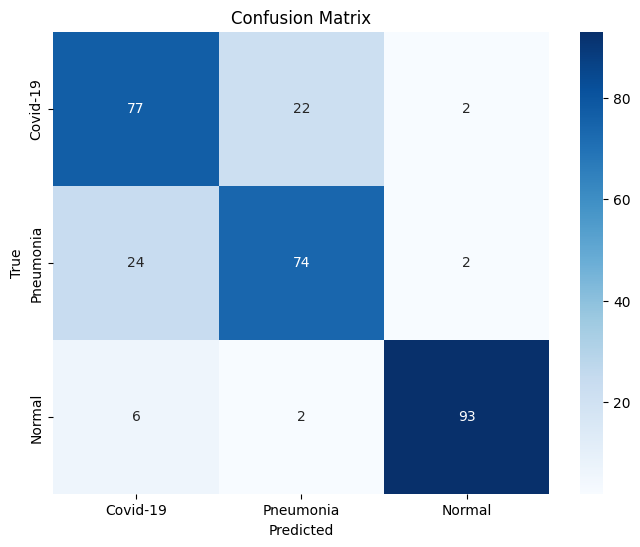

In [43]:
cm = confusion_matrix(true_labels, y_predicted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Covid-19', 'Pneumonia', 'Normal'], 
            yticklabels=['Covid-19', 'Pneumonia', 'Normal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True') 
plt.show()

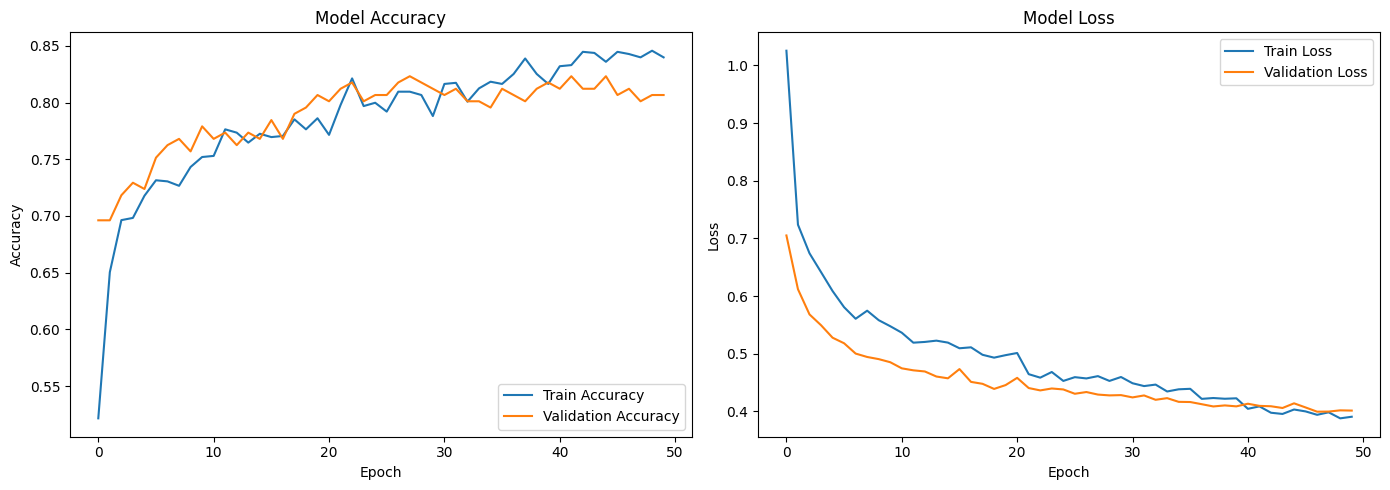

In [44]:
# Extract metrics from history
acc = DenseNet121_history.history['accuracy']
val_acc = DenseNet121_history.history['val_accuracy']
loss = DenseNet121_history.history['loss']
val_loss = DenseNet121_history.history['val_loss']

epochs_range = range(len(acc))

# Plot
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

# from Scratch SHAP(permuatation_importance)

In [47]:
def permutation_importance(image, model, class_index, model_name, raw_image, num_permutation=50):
    image = np.expand_dims(image, axis=0)
    correct_prob = model.predict(image, verbose=0)[0, class_index]

    step_size = 24
    importance_map = np.zeros((224, 224))
    count_map = np.zeros((224, 224))

    for _ in range(num_permutation):
        i = np.random.randint(0, 224)
        j = np.random.randint(0, 224)

        i_end = min(i + step_size, 224)
        j_end = min(j + step_size, 224)

        perturbed = image.copy()
        perturbed[0, i:i_end, j:j_end, :] = np.random.rand(i_end - i, j_end - j, 3)

        pred_prob = model.predict(perturbed, verbose=0)[0, class_index]
        importance = correct_prob - pred_prob
        importance_map[i:i_end, j:j_end] += importance
        count_map[i:i_end, j:j_end] += 1

    importance_map = np.divide(importance_map, count_map, out=np.zeros_like(importance_map), where=count_map != 0)

    if np.max(importance_map) - np.min(importance_map) > 0:
        importance_map = (importance_map - np.min(importance_map)) / (np.max(importance_map) - np.min(importance_map) + 1e-8)
    else:
        importance_map = np.zeros_like(importance_map)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(raw_image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(raw_image)
    plt.imshow(importance_map, cmap='hot', alpha=0.5)
    plt.title(f"{model_name} Importance")
    plt.axis('off')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

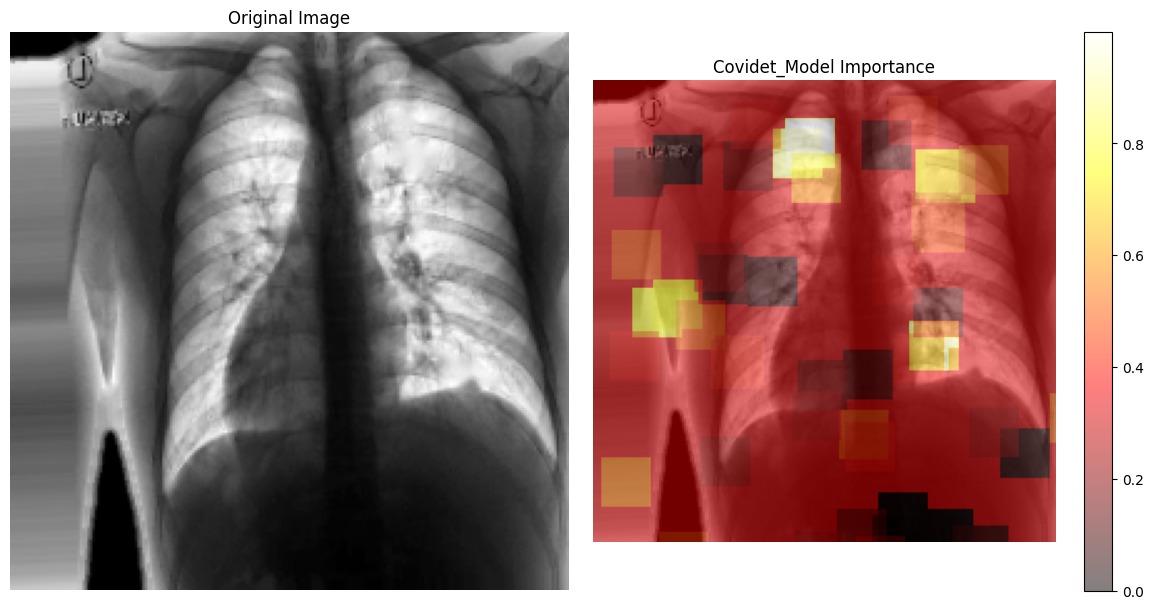

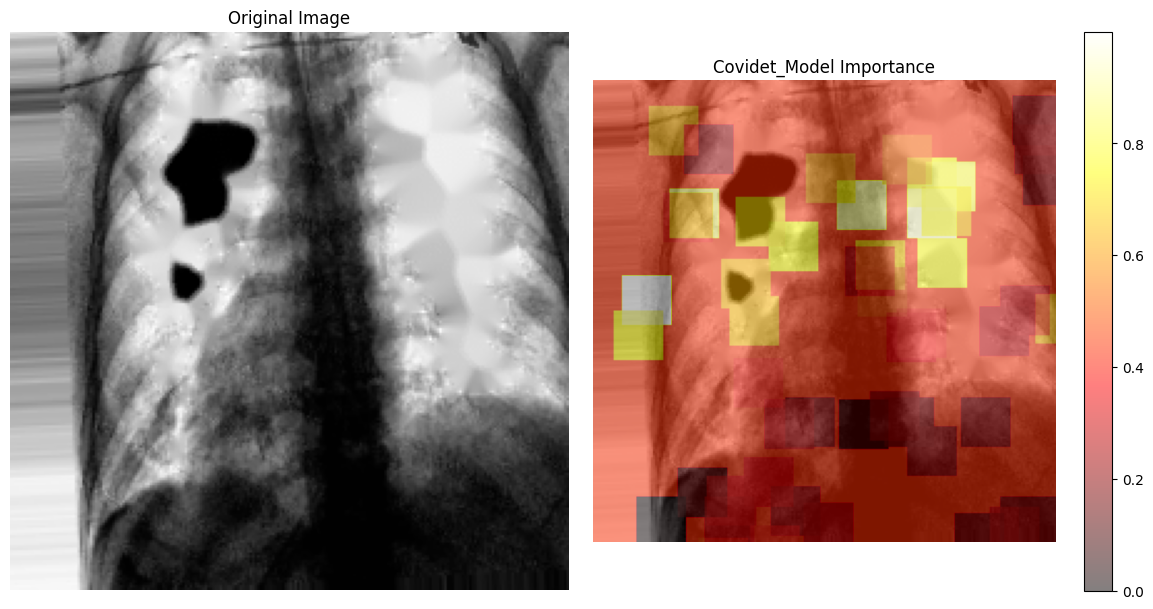

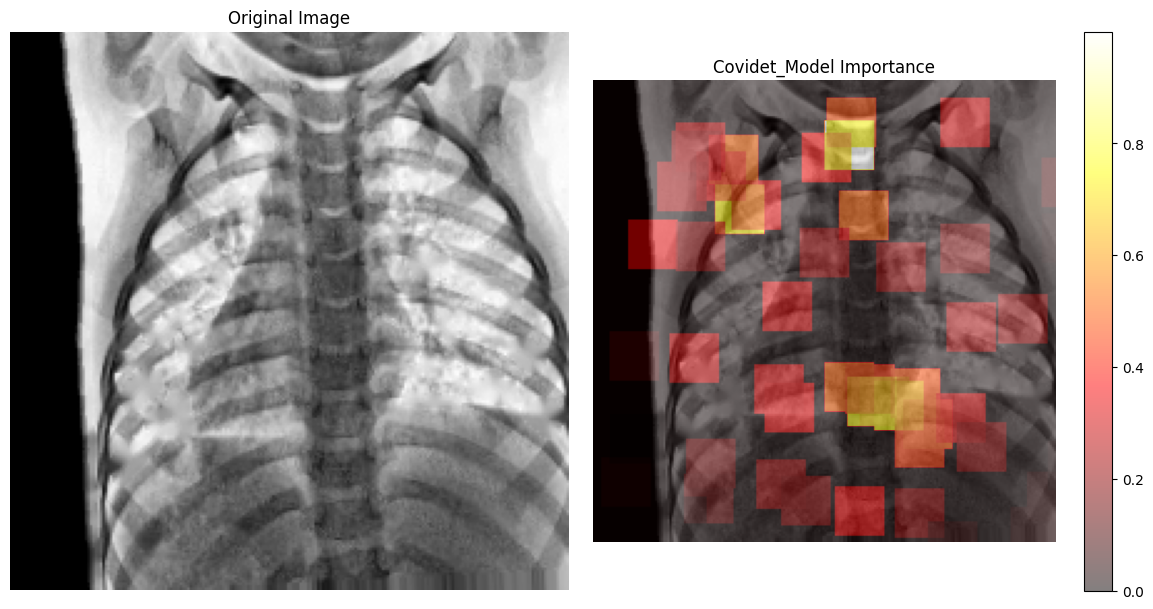

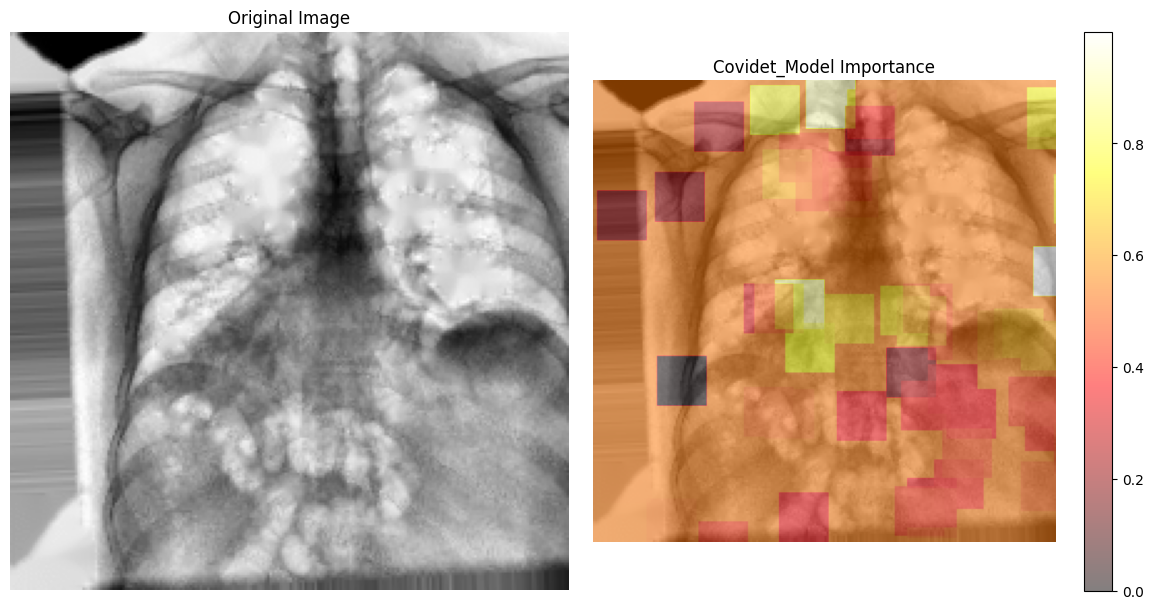

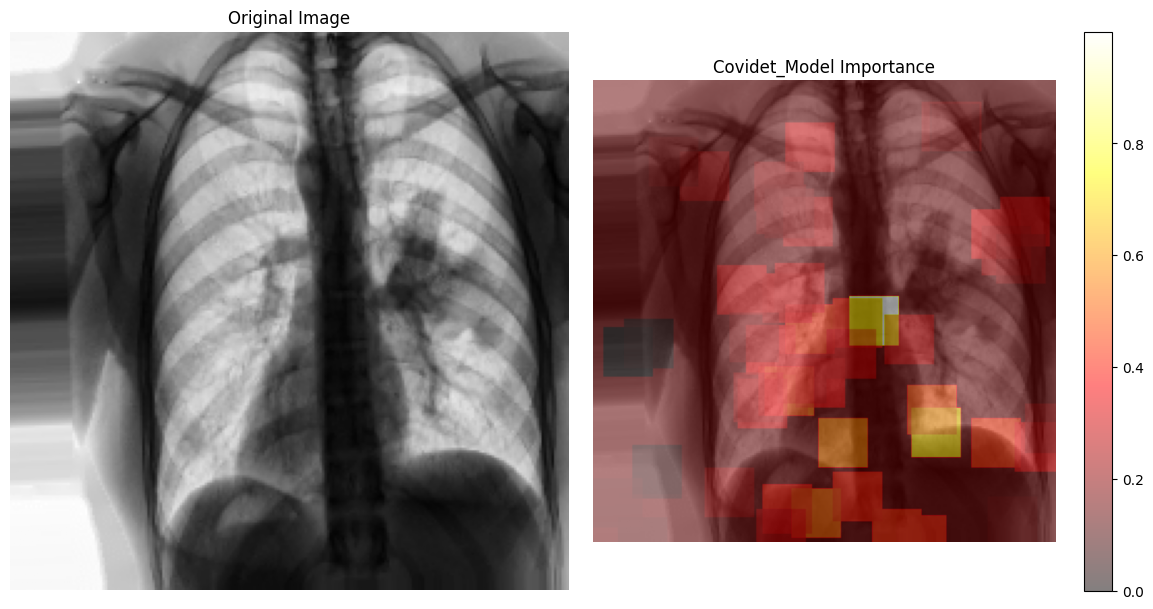

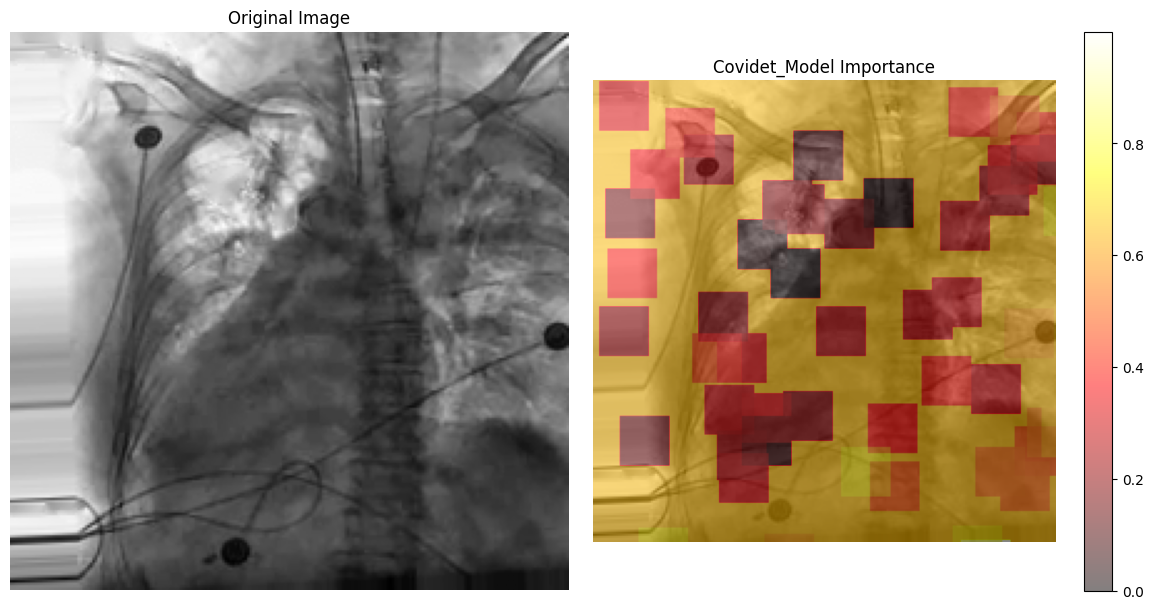

In [46]:
random_indices = random.sample(range(len(test_images)), 6)

for idx in random_indices:
    image = test_images[idx]
    label_one_hot = test_labels_one_hot[idx]
    true_class_index = np.argmax(label_one_hot)

    permutation_importance(image=image, model=DenseNet121_finetuned, class_index=true_class_index, model_name="Covidet_Model", raw_image=image)

# DeepLIFT

In [48]:
def deeplift(model, img, baseline=None, pred_index=None):
    if baseline is None:
        baseline = np.zeros_like(img)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)
    
    # difference between input and baseline
    diff = img - baseline
    
    # gradients of the predicted class VS respect to the input
    with tf.GradientTape() as tape:
        tape.watch(img)
        preds = model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        score = preds[:, pred_index]
    
    grads = tape.gradient(score, img)
    
    # DeepLIFT multipliers: approximate as gradients
    multipliers = grads
    
    # contribution scores: (input - baseline) * multipliers
    contributions = diff * multipliers
    
    # Sum across channels + absolute
    heatmap = tf.reduce_sum(tf.abs(contributions), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-10)  # Normalize
    return heatmap, pred_index

In [49]:
def display_heatmap(img, heatmap, alpha=0.5):
    if img.ndim == 4:
        img = img[0]
    if heatmap.ndim == 3:
        heatmap = heatmap[0]
    
    img = np.uint8(255 * (img - img.min()) / (img.max() - img.min() + 1e-10))
    
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(heatmap[..., np.newaxis], (img.shape[0], img.shape[1])).numpy()[..., 0]
    heatmap = np.uint8(plt.cm.jet(heatmap)[..., :3] * 255)
    
    superimposed_img = heatmap * alpha + img * (1 - alpha)
    return np.uint8(superimposed_img)

In [50]:
# Select 3 samples per class
num_classes = 3
samples_per_class = 1
class_indices = np.argmax(test_labels_one_hot, axis=1)

selected_images = []
selected_labels = []

for class_idx in range(num_classes):
    # Find indices of samples belonging to this class
    class_samples = np.where(class_indices == class_idx)[0]
    if len(class_samples) < samples_per_class:
        print(f"Warning: Class {class_idx} has only {len(class_samples)} samples, using all available.")
        selected_samples = class_samples
    else:
        selected_samples = np.random.choice(class_samples, size=samples_per_class, replace=False)
    
    selected_images.extend(test_images[selected_samples])
    selected_labels.extend(test_labels[selected_samples])

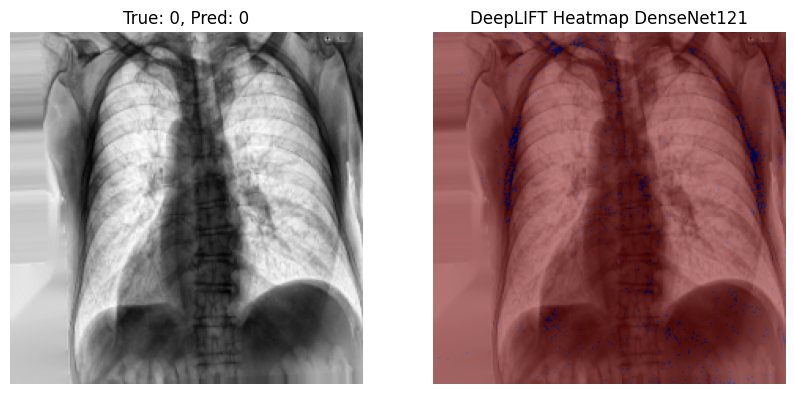

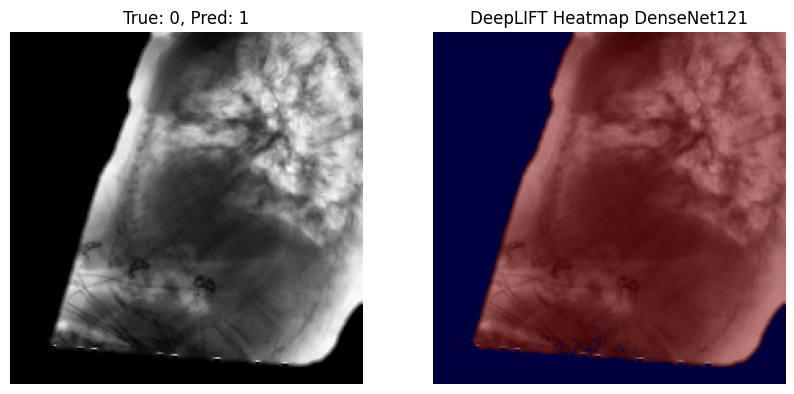

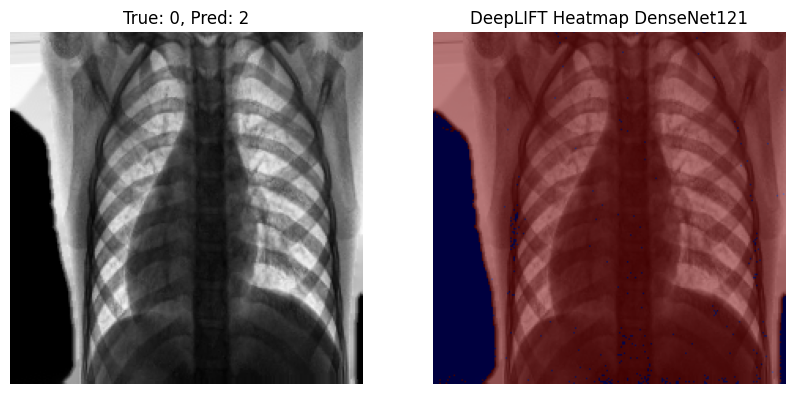

In [51]:
sample_images = np.array(selected_images)
sample_labels = np.array(selected_labels)

for i in range(len(sample_images)):
    img = sample_images[i:i+1]
    true_label = np.argmax(sample_labels[i])
    
    heatmap, pred_class = deeplift(DenseNet121_finetuned, img)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.title(f"True: {true_label}, Pred: {pred_class}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    superimposed_img = display_heatmap(img, heatmap)
    plt.imshow(superimposed_img)
    plt.title("DeepLIFT Heatmap DenseNet121")
    plt.axis('off')
    
    plt.show()

# LIME

In [52]:
def preprocess_image(image_path):
    try:
        img = imread(image_path, as_gray=False)
        img = resize(img, (224, 224), anti_aliasing=True)
        if len(img.shape) == 2:
            img_rgb = np.stack([img] * 3, axis=-1)
        elif img.shape[-1] == 1:
            img_rgb = np.repeat(img, 3, axis=-1)
        else:
            img_rgb = img
        img_normalized = img_rgb / 255.0 if img_rgb.max() > 1 else img_rgb
        if len(img.shape) == 2 or (len(img.shape) == 3 and np.all(img[:, :, 0] == img[:, :, 1]) and np.all(img[:, :, 1] == img[:, :, 2])):
            img_viz = img if len(img.shape) == 2 else img[:, :, 0]
        else:
            img_viz = img_rgb
        return img_normalized, img_viz
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None, None

In [53]:
def explain_with_lime(model, image_paths_with_labels):
    explainer = lime_image.LimeImageExplainer()
    segmenter = SegmentationAlgorithm('quickshift', kernel_size=2, max_dist=100, ratio=0.2)

    for image_path, class_name in image_paths_with_labels:
        img_normalized, img_viz = preprocess_image(image_path)
        if img_normalized is None:
            print(f"Skipping {image_path} due to preprocessing error.")
            continue

        try:
            explanation = explainer.explain_instance(
                img_normalized,
                DenseNet201_finetuned.predict,
                top_labels=3,
                hide_color=None,
                num_samples=500,
                segmentation_fn=segmenter
            )
        except Exception as e:
            print(f"Error explaining image {image_path}: {e}")
            continue

        pred = model.predict(np.expand_dims(img_normalized, axis=0), verbose=0)
        predicted_class = class_labels[np.argmax(pred)]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        ax1.imshow(img_viz, cmap='gray' if len(img_viz.shape) == 2 else None)
        ax1.set_title(f'Original ({class_name})\nPredicted: {predicted_class}')
        ax1.axis('off')

        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False
        )

        base_image = img_viz
        if len(base_image.shape) == 2:
            overlay = np.zeros_like(base_image)
            overlay[mask == 1] = 1
            alpha = 0.3
            highlighted_image = (1 - alpha) * base_image + alpha * overlay
            highlighted_image = np.clip(highlighted_image, 0, 1)
            cmap = 'gray'
        else:
            overlay = np.zeros_like(base_image)
            overlay[mask == 1] = [1, 0, 0]
            alpha = 0.3
            highlighted_image = (1 - alpha) * base_image + alpha * overlay
            highlighted_image = np.clip(highlighted_image, 0, 1)
            cmap = None

        highlighted_image = mark_boundaries(highlighted_image, mask, color=(1, 0, 0), mode='thick')
        ax2.imshow(highlighted_image, cmap=cmap)
        ax2.set_title('LIME Highlights')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Image: {image_path}")
        print(f"Predicted probabilities: {dict(zip(class_labels, pred[0]))}\n")

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

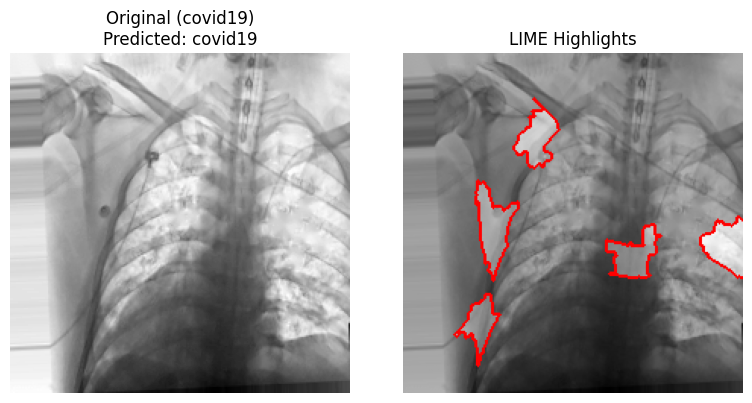

Image: /kaggle/input/feature-selelcted-dataset/test/covid19/image_253.png
Predicted probabilities: {'covid19': 0.8282515, 'normal': 0.15545742, 'pneumonia': 0.016291136}



  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

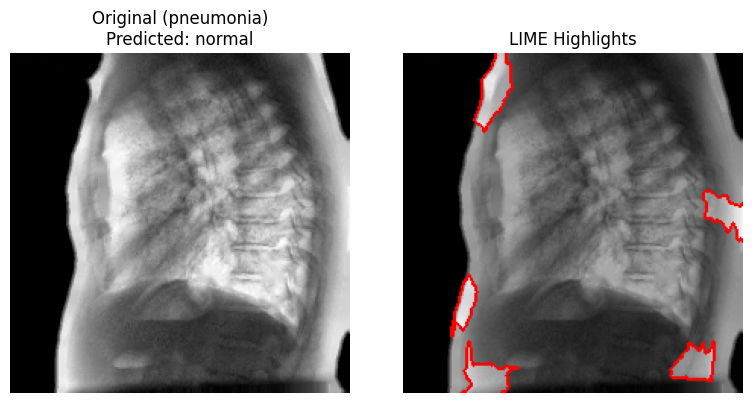

Image: /kaggle/input/feature-selelcted-dataset/test/pneumonia/image_281.png
Predicted probabilities: {'covid19': 0.14822301, 'normal': 0.8210409, 'pneumonia': 0.03073608}



  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

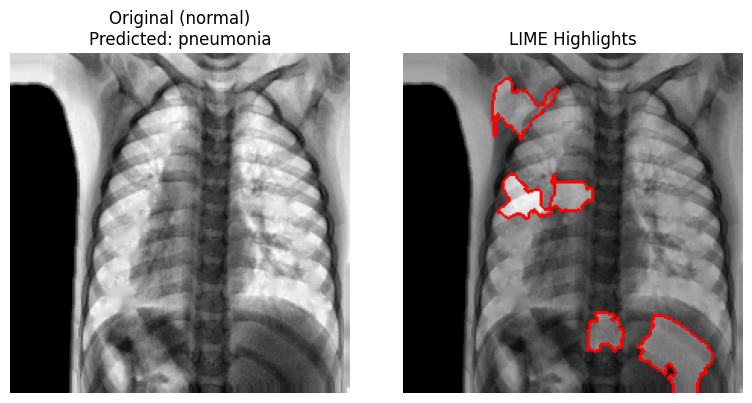

Image: /kaggle/input/feature-selelcted-dataset/test/normal/image_301.png
Predicted probabilities: {'covid19': 0.00081131805, 'normal': 0.0004795472, 'pneumonia': 0.9987091}



In [54]:
class_labels = ['covid19', 'normal', 'pneumonia']
test_dir = '/kaggle/input/feature-selelcted-dataset/test'
try:
    image_paths = [
        (os.path.join(test_dir, 'covid19', os.listdir(os.path.join(test_dir, 'covid19'))[0]), 'covid19'),
        (os.path.join(test_dir, 'pneumonia', os.listdir(os.path.join(test_dir, 'pneumonia'))[0]), 'pneumonia'),
        (os.path.join(test_dir, 'normal', os.listdir(os.path.join(test_dir, 'normal'))[0]), 'normal')
    ]
    explain_with_lime(DenseNet121_finetuned, image_paths)
except Exception as e:
    print(f"Error loading sample images: {e}")

# GRAD-CAM

In [57]:
def gradCam(image, true_label, layer_conv_name, model):
    model_grad = tf.keras.models.Model(inputs=model.input, 
                                       outputs=[model.get_layer(layer_conv_name).output, 
                                                model.output])
    pred = []
    with tf.GradientTape() as tape:
        conv_output, predictions = model_grad(image)

        pred.append(np.argmax(predictions))
        
        tape.watch(conv_output)
        loss = tf.keras.losses.categorical_crossentropy(true_label, predictions)
    
    grad = tape.gradient(loss, conv_output)
    grad = tf.reduce_mean(tf.abs(grad), axis=(0, 1, 2))
    
    conv_output = np.squeeze(conv_output.numpy())
    
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= grad[i]
        
    heatmap = tf.reduce_mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap + 1e-8)  
    heatmap = cv2.resize(heatmap.numpy(), (224, 224))
    pred = np.array(pred)
    return np.squeeze(heatmap), np.squeeze(image), pred

In [58]:
def getHeatMap(images, labels, model, block_name):
    heatmaps = []
    predictions = []
    for index in range(128):
        heatmap, image, pred = gradCam(images[index:index+1], 
                                 labels[index:index+1], 
                               block_name, model) 
        heatmaps.append(heatmap)
        predictions.append(pred)
    return np.array(heatmaps), predictions


(128, 224, 224)


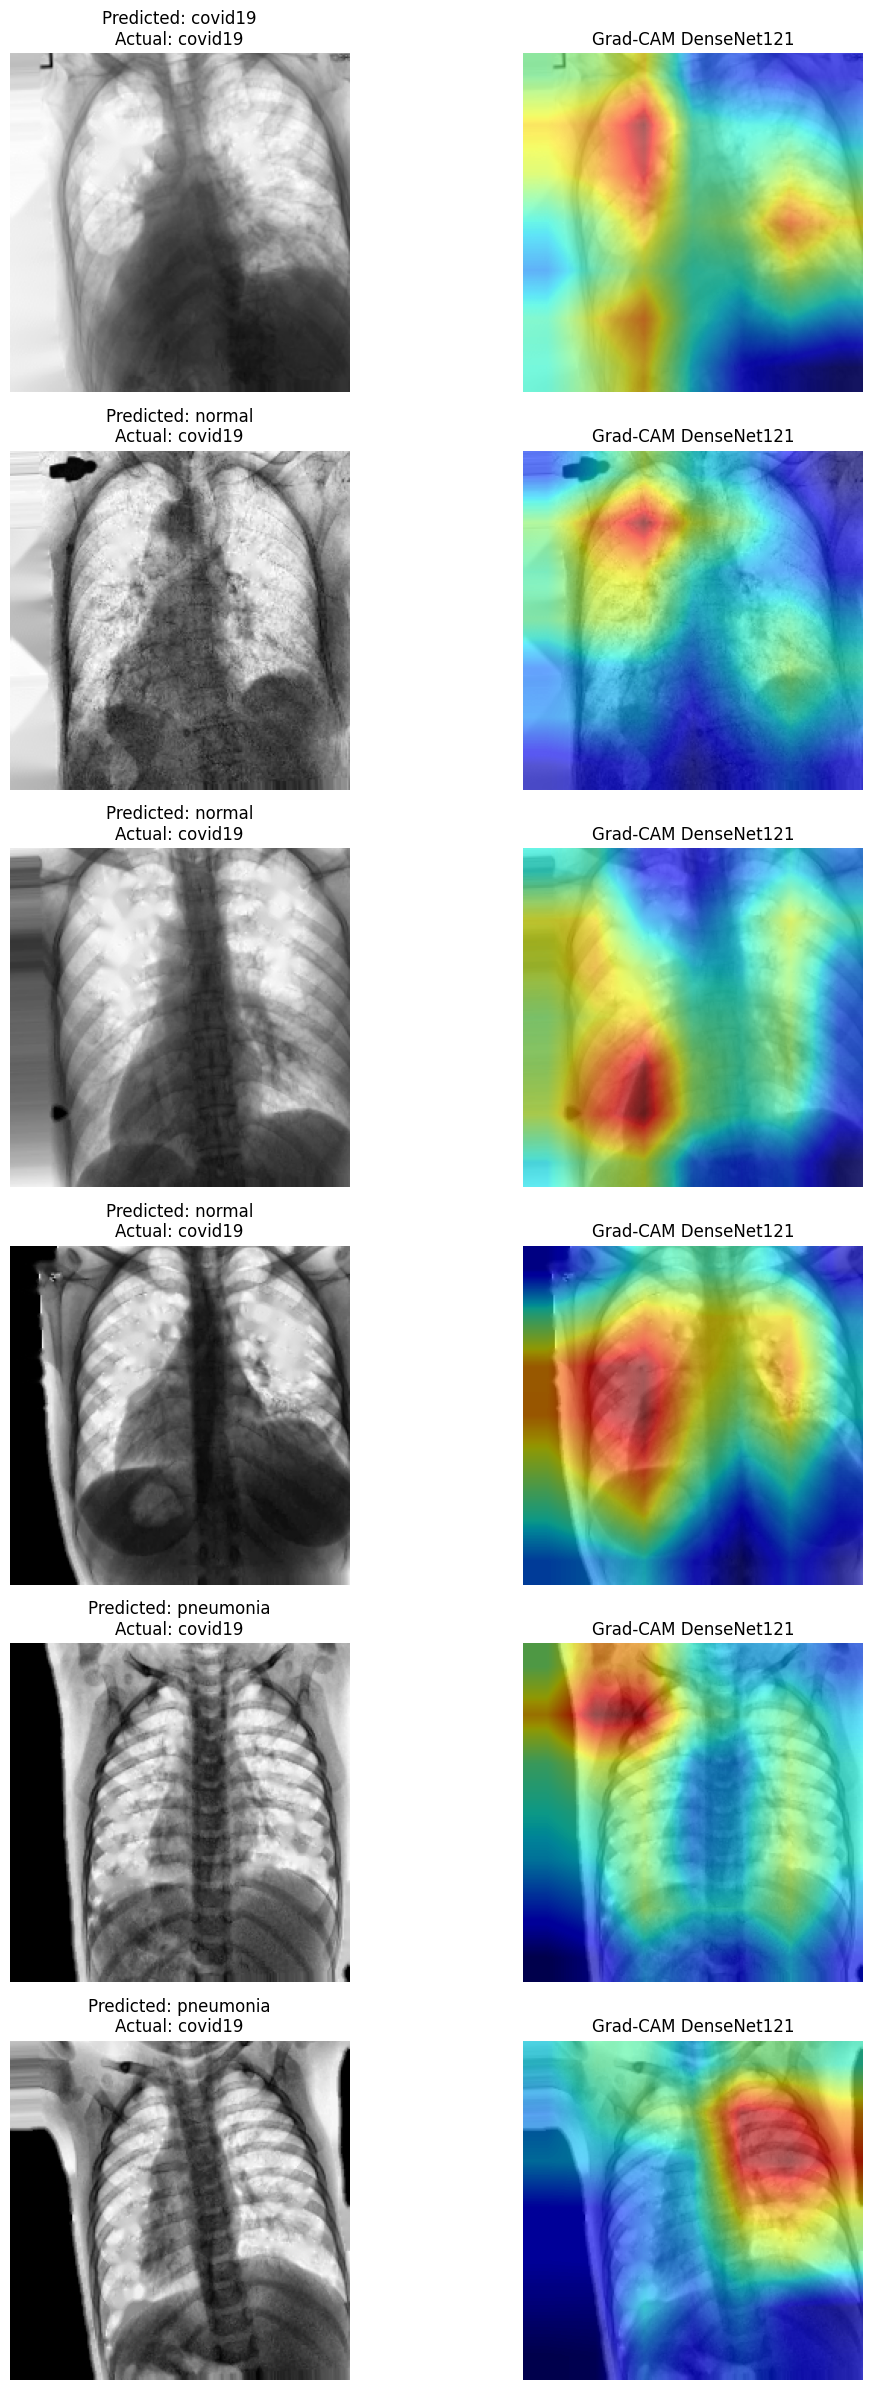

In [59]:
heatmaps, pred = getHeatMap(test_images, test_labels_one_hot, DenseNet121_finetuned, 'conv5_block16_2_conv')
print(heatmaps.shape)  

class_dict_c = {0:'covid19',
              1:'normal',
              2:'pneumonia'}
def draw(images, gradcam_heatmaps, labels, pred,  num_images=6):
    plt.figure(figsize=(12, 4 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(images[i])
        title_pred = class_dict_c[pred[i][0]]
        title_actual = class_dict_c[np.argmax(labels[i])]
        plt.title(f'Predicted: {title_pred}\nActual: {title_actual}')

  
        
        plt.axis('off')

        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(images[i])
        plt.imshow(gradcam_heatmaps[i], alpha=0.6, cmap='jet')
        plt.title('Grad-CAM DenseNet121')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

draw(test_images[:6], heatmaps[:6], test_labels[:6],pred)